# Harmonic oscillator

This notebook demonstrates how to numerically integrate an **ordinary differential equation** (ODE) with `scipy.integrate.solve_ivp`. An undamped/damped harmonic oscillator serves as a well-known example. Surprisingly many real dynamical systems and their oscillatory phenomena can be understood — at least approximately — on the basis of such simple models.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Let $x$ denote the displacement from equilibrium. The **simple harmonic oscillator** is then described by the equation $m \ddot{x} = -k x$, where $m$ is the mass and $k$ is the spring constant. Similarly, a **damped harmonic oscillator** with a damping coefficient $c$ is modeled as $m \ddot{x} = -k x - c \dot{x}$. When the system is additionally subjected to an external time-dependent force $F$, one can represent the **driven and damped harmonic oscillator** by
$$
m \frac{\mathrm{d}^2 x}{\mathrm{d} t^2}(t) = -k x - c \frac{\mathrm{d} x}{\mathrm{d} t}(t) + F(t).
$$

This is often rewritten as $\ddot{x} + 2 \zeta \omega_0 \dot{x} + \omega_0^2 x = F / m$. Here, $\omega_0 = \sqrt{k / m}$ is the undamped angular natural frequency. The so-called damping ratio $\zeta = c \left( 2 \sqrt{m k} \right)^{-1}$ determines whether the damped harmonic oscillator is overdamped ($\zeta>1$), critically damped ($\zeta=1$) or underdamped ($\zeta<1$).

Using the displacement $x_1 = x$ and the velocity $x_2 = \dot{x}$ as state variables $\boldsymbol{x} = (x_1, x_2)^\top$, and assuming that only the first component is observed, the **state-space representation** of the mass-spring-damper system is
$$
\underbrace{\begin{pmatrix} \dot{x}_1 \\ \dot{x}_2 \end{pmatrix}}_\dot{\boldsymbol{x}} =
\underbrace{\begin{pmatrix} 0 & 1 \\ -k/m & -c/m \end{pmatrix}}_\boldsymbol{A}
\underbrace{\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}}_\boldsymbol{x} +
\underbrace{\begin{pmatrix} 0 \\ 1/m \end{pmatrix}}_\boldsymbol{B}
\underbrace{F}_\boldsymbol{u}, \quad
\underbrace{x_1}_\boldsymbol{y} =
\underbrace{\begin{pmatrix} 1 & 0 \end{pmatrix}}_\boldsymbol{C}
\underbrace{\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}}_\boldsymbol{x}.
$$

The second-order ODE has been reduced to a first-order system. Below we define a function that constructs the state, input and output matrices $\boldsymbol{A}, \boldsymbol{B}, \boldsymbol{C}$ based on the values of the physical parameters $m, k, c$. It can be optionally chosen which variables are observed.

In [3]:
def assemble_matrices(m, k, c, obs_mode='displacement'):
    '''
    Assemble the matrices of the state-space formulation.

    Parameters
    ----------
    m : float
        Mass [kg].
    k : float
        Spring constant [N/m].
    c : float
        Damping coefficient [N*s/m].
    obs_mode : {'displacement', 'velocity', 'both'}
        Determines which outputs are observed.

    '''

    # state matrix
    A = np.array(
        [[0., 1.],
         [-k/m, -c/m]]
    )

    # input matrix
    B = np.array(
        [[0.],
         [1/m]]
    )

    # output matrix
    if obs_mode == 'displacement':
        C = np.array([[1, 0]])
    elif obs_mode == 'velocity':
        C = np.array([[0, 1]])
    elif obs_mode == 'both':
        C = np.array(
            [[1, 0],
             [0, 1]]
        )
    else:
        raise ValueError('Invalid observation mode: {}'.format(obs_mode))

    return A, B, C

We also need a function that calculates the derivatives $\dot{\boldsymbol{x}} = (\dot{x}_1, \dot{x}_2)^\top = \boldsymbol{A} \boldsymbol{x} + \boldsymbol{B} \boldsymbol{u}$ of the state variables, i.e. the right-hand side of the coupled system of first-order ODEs that describes the time evolution. Note that no forcing is applied here.

In [4]:
def dxdt(t, x, A):
    '''
    Compute the time derivatives of the two
    state variables in the undriven system.

    Parameters
    ----------
    t : float
        Time [s].
    x : array-like
        State vector.
    A : array-like
        State matrix.

    '''

    return np.matmul(A, x)

## Simple harmonic oscillator

One can consider an undamped oscillator by setting the physical parameters to some hypothetical values and creating the corresponding state-space matrices with our function `assemble_matrices`.

In [5]:
m = 1 # mass
k = 1 # spring constant
c = 0 # damping coefficient

A, B, C = assemble_matrices(m, k, c) # state-space matrices

An initial state and a time interval have to be specified, too. The initial value problem is numerically solved by `solve_ivp` for a number of time steps.

In [6]:
initial_state = np.array([0.01, 0])
time_interval = (0, 20)
num_steps = 1001

# time evolution
res = solve_ivp(
    dxdt, time_interval, initial_state, 
    t_eval=np.linspace(*time_interval, num_steps),
    args=(A,)
)

# observations
numerical_displacements = np.matmul(C, res.y) 

The displacement observations were extracted in the last line. Of course, one can analytically solve that classical problem as follows.

In [7]:
nat_freq = np.sqrt(k/m)

analytical_displacements = initial_state[0] * np.cos(nat_freq * res.t) \
                         + initial_state[1] / nat_freq * np.sin(nat_freq * res.t)

Let us now compare the analytical and numerical solution. Isn't that beautiful?

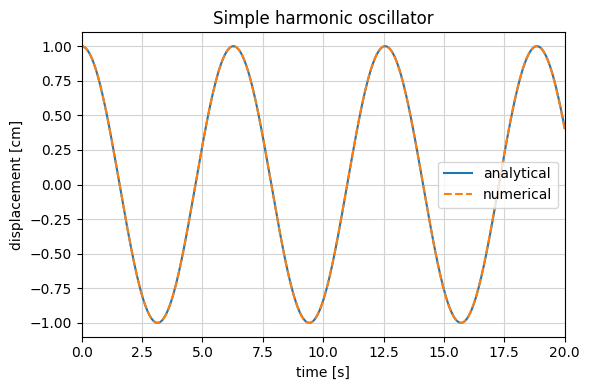

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(res.t, analytical_displacements*100, label='analytical')
ax.plot(res.t, numerical_displacements[0,:]*100, linestyle='--', label='numerical')
ax.set(xlabel='time [s]', ylabel='displacement [cm]', xlim=time_interval)
ax.set_title('Simple harmonic oscillator')
ax.legend()
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Damped harmonic oscillator

For the damped oscillator, three different sets of matrices represent the underdamped, critically damped and overdamped case, respectively.

In [9]:
A_under, B_under, C_under = assemble_matrices(m=1, k=1, c=0.5) # underdamped
A_critic, B_critic, C_critic = assemble_matrices(m=1, k=1, c=1) # critically damped
A_over, B_over, C_over = assemble_matrices(m=1, k=1, c=2) # overdamped

As before, the equations are numerically integrated, after which the outputs are computed.

In [10]:
initial_state = np.array([0.01, 0])
time_interval = (0, 20)
num_steps = 1001

# time evolution
res_under = solve_ivp(
    dxdt, time_interval, initial_state,
    t_eval=np.linspace(*time_interval, num_steps),
    args=(A_under,)
)

res_critic = solve_ivp(
    dxdt, time_interval, initial_state,
    t_eval=np.linspace(*time_interval, num_steps),
    args=(A_critic,)
)

res_over = solve_ivp(
    dxdt, time_interval, initial_state,
    t_eval=np.linspace(*time_interval, num_steps),
    args=(A_over,)
)

# observations
y_under = np.matmul(C, res_under.y)
y_critic = np.matmul(C, res_critic.y)
y_over = np.matmul(C, res_over.y)

Finally, we plot the behaviors of the three different scenarios.

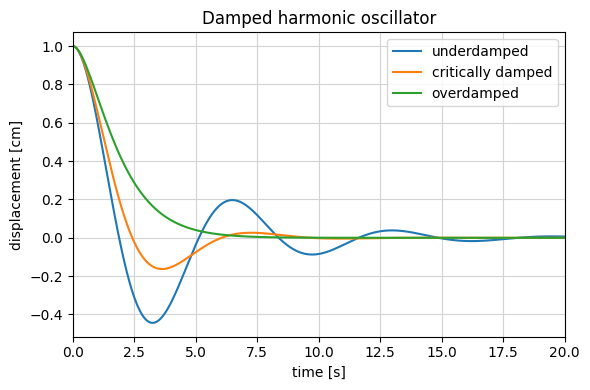

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(res_under.t, y_under[0,:]*100, label='underdamped')
ax.plot(res_critic.t, y_critic[0,:]*100, label='critically damped')
ax.plot(res_over.t, y_over[0,:]*100, label='overdamped')
ax.set(xlabel='time [s]', ylabel='displacement [cm]', xlim=time_interval)
ax.set_title('Damped harmonic oscillator')
ax.legend()
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

The driven oscillator, e.g. with an external sinusoidal force, can be analogously simulated. One simply has to add a forcing term to the function `dxdt` that implements the derivatives. Resonance frequencies can be fun!